In [2]:
import os, pathlib, shutil
import zipfile
from dataclasses import dataclass
import matplotlib.pyplot as plt 
from PIL import Image
import random
import numpy as np 
from tensorflow.keras import layers, Sequential

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# set seed

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    try:
        physical_devices = tf.config.list_physical_devices('GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass

set_seed()

In [4]:
# extract 

def unzip_file(zip_file=None):

    try: 
        with zipfile.ZipFile(zip_file) as z:
            z.extractall('./')
        print("File Extracted.")

    except:
        print('File not found.')


# unzip_file(zip_file='archive.zip')

In [14]:
@dataclass
class DataConfig:
    ROOT_DIR: str = r'C:\Users\Khemra\Desktop\OpenCV\Kaggle Flowers Project\flower_images'
    BATCH_SIZE: int = 32
    SEED_VALUE: int = 42
    IMG_SIZE: tuple = (180, 180)
    IMG_SHAPE: tuple = (180, 180, 3)
    CLASS_MODE: str = 'categorical'
    COLOR_MODE: str = 'rgb'

In [6]:
# List directory structure 

def list_dir_structure(root_dir):

    for root, _, file in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')

list_dir_structure(DataConfig.ROOT_DIR)

flower_images
    Lilly   
    Lotus   
    Orchid  
    Sunflower
    Tulip   


In [7]:
# show how many images in each class 

def num_of_images(root_dir):

    num_of_images = 0 

    for path in os.listdir(root_dir):
        num_of_images += len(os.listdir(os.path.join(root_dir, path)))

    print(f'Number of images: {num_of_images}')

num_of_images(DataConfig.ROOT_DIR)

Number of images: 5000


### Need to split these into Train, Test, and Valid folders. 

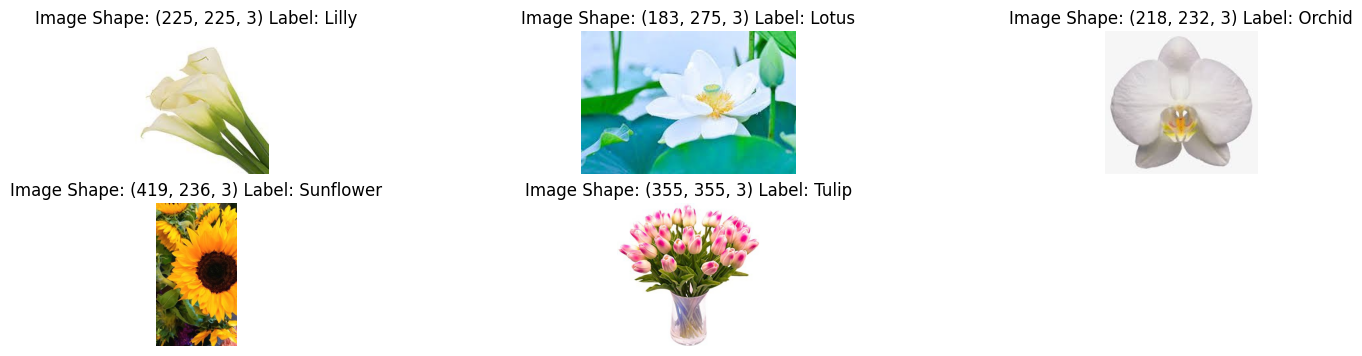

In [8]:
# display a few images with their labels in a grid 

def display_dataset_grid(data_dir):

    class_names = os.listdir(data_dir)
    plt.figure(figsize=(18, 13))

    for idx, class_names in enumerate(class_names):

        ax = plt.subplot(6, 3, idx + 1)
        image_tensor = tf.keras.utils.img_to_array(Image.open(os.path.join(data_dir, class_names, os.listdir(os.path.join(data_dir, class_names))[0])))
        image_shape = image_tensor.shape
        plt.imshow(Image.open(os.path.join(data_dir, class_names, os.listdir(os.path.join(data_dir, class_names))[0])))
        plt.title(label='Image Shape: {}'.format(image_shape) + ' Label: {}'.format(class_names))
        plt.axis('off')

display_dataset_grid(DataConfig.ROOT_DIR)

In [9]:
new_base_dir = pathlib.Path('flowers_datasets')
original_path = pathlib.Path('flower_images') 

def make_subset(subset_name, start_num, end_num):
    for category in ('Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        # file_count = 0
        for file_name in os.listdir(original_path / category)[start_num:end_num]:
            if file_name.endswith('.jpg'): #and file_count < num_of_images:
                src_file = original_path / category / file_name
                dst_subdir = new_base_dir / subset_name / category 
                dst_file = dst_subdir / file_name
                shutil.copy(src_file, dst_file)
                # file_count += 1
                # if file_count >= num_of_images:
                #     break


        

# make_subset("Train", start_num=0, end_num=700)
# make_subset("Valid", start_num=700, end_num=900)
# make_subset("Test", start_num=900, end_num=1000)

In [10]:
# show directory tree 
flower_dataset_dir = os.path.join(os.getcwd(), 'flowers_datasets')
list_dir_structure(flower_dataset_dir)

flowers_datasets
    Test    
        Lilly   
        Lotus   
        Orchid  
        Sunflower
        Tulip   
    Train   
        Lilly   
        Lotus   
        Orchid  
        Sunflower
        Tulip   
    Valid   
        Lilly   
        Lotus   
        Orchid  
        Sunflower
        Tulip   


In [11]:
# show how many images in each class
train_dir = os.path.join(flower_dataset_dir, 'Train')
valid_dir = os.path.join(flower_dataset_dir, 'Valid')
test_dir = os.path.join(flower_dataset_dir, 'Test')

num_of_images(train_dir)
num_of_images(valid_dir)
num_of_images(test_dir)

Number of images: 3500
Number of images: 1000
Number of images: 500


### GET DATA()

In [15]:


def get_data(train_folder, valid_folder):

    train_dir = os.path.join(flower_dataset_dir, train_folder)
    valid_dir = os.path.join(flower_dataset_dir, valid_folder)

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=DataConfig.IMG_SIZE,
        batch_size=DataConfig.BATCH_SIZE,
        label_mode=DataConfig.CLASS_MODE,
        color_mode=DataConfig.COLOR_MODE,
        shuffle=True,
    )

    valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        valid_dir,
        image_size=DataConfig.IMG_SIZE,
        batch_size=DataConfig.BATCH_SIZE,
        label_mode=DataConfig.CLASS_MODE,
        color_mode=DataConfig.COLOR_MODE,
        shuffle=False,

    )

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, valid_dataset

train_dataset, valid_dataset = get_data('Train', 'Valid')

Found 3500 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


## Augment a few images and display the output 

In [13]:
# augmentation zoom layer 

rand_zoom = tf.keras.layers.experimental.preprocessing.RandomZoom(.5, .2, fill_mode='reflect', interpolation='bilinear', seed=2000)

In [16]:
# function for augmenting images and displaying them

def display_augmenation(dataset, augmentation_layer, num_of_passes=24, label=None):
    
        plt.figure(figsize=(12, 12))
        random.seed(DataConfig.SEED_VALUE)
    
        for images, _, in dataset.take(1):
            aug_images = augmentation_layer(images)
            for i in range(num_of_passes):
                ax = plt.subplot(6, 4, i + 1)
                plt.imshow(aug_images[i].numpy().astype('uint8'))
                plt.title(label=label)
                plt.axis('off')
            

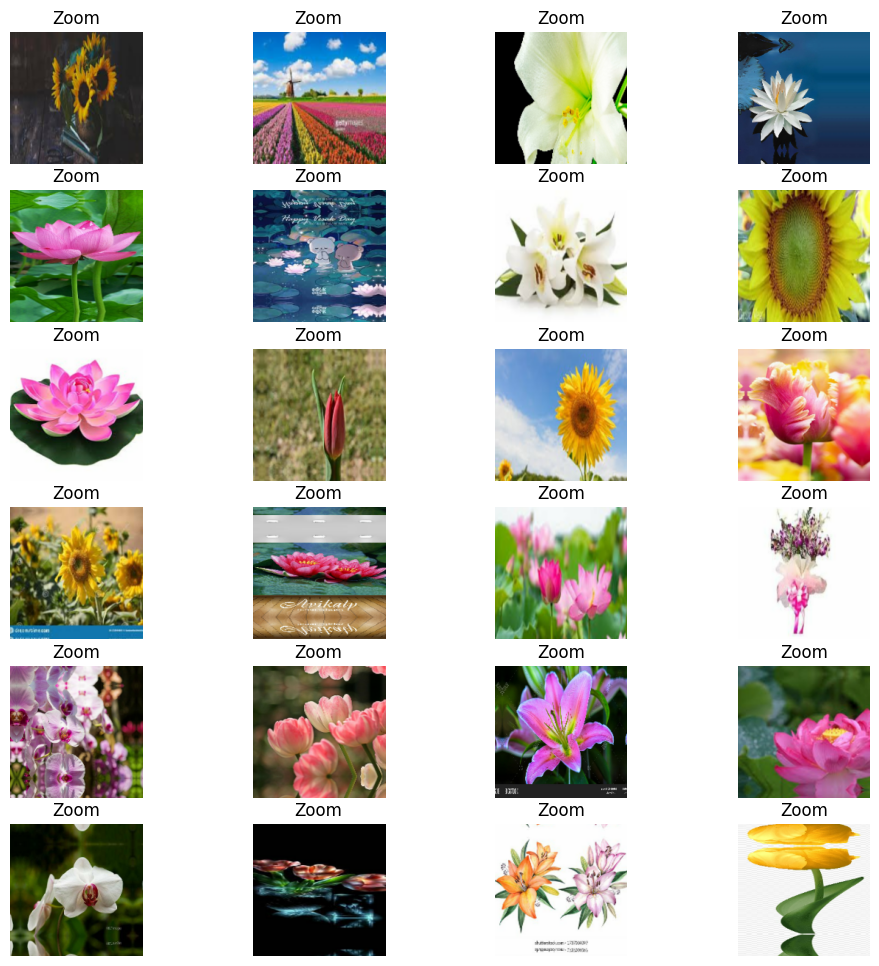

In [17]:
display_augmenation(train_dataset, rand_zoom, num_of_passes=24, label='Zoom')